In [6]:
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import re
import requests
from bs4 import BeautifulSoup
res = requests.get("https://www.pro-football-reference.com/years/2021/fantasy.htm")
soup = BeautifulSoup(res.text,features='html.parser')

tbody = soup.find_all("tbody")[-1]

usernames = []

for tr in tbody.find_all("tr"):
    if(tr.get("class") is not None and tr.get("class")[0] == "thead"):
        continue
    first = tr.td
    a = first.a
    pos = first.next_sibling.next_sibling.text.lower()
    if(pos != ""):
        username = re.search("\/(.{6}\d{2}).htm", a.get("href")).group(1)
        usernames.append((username, pos))
usernames

[('TaylJo02', 'rb'),
 ('KuppCo00', 'wr'),
 ('SamuDe00', 'wr'),
 ('AlleJo02', 'qb'),
 ('EkelAu00', 'rb'),
 ('HerbJu00', 'qb'),
 ('BradTo00', 'qb'),
 ('AndrMa00', 'te'),
 ('ChasJa00', 'wr'),
 ('JeffJu00', 'wr'),
 ('MixoJo00', 'rb'),
 ('AdamDa01', 'wr'),
 ('MahoPa00', 'qb'),
 ('HarrNa00', 'rb'),
 ('KelcTr00', 'te'),
 ('ConnJa00', 'rb'),
 ('EvanMi00', 'wr'),
 ('RodgAa00', 'qb'),
 ('HillTy00', 'wr'),
 ('StafMa00', 'qb'),
 ('DiggSt00', 'wr'),
 ('ElliEz00', 'rb'),
 ('PresDa01', 'qb'),
 ('ChubNi00', 'rb'),
 ('WillMi07', 'wr'),
 ('MetcDK00', 'wr'),
 ('LockTy00', 'wr'),
 ('HarrDa06', 'rb'),
 ('BurrJo01', 'qb'),
 ('JohnDi01', 'wr'),
 ('HurtJa00', 'qb'),
 ('KamaAl00', 'rb'),
 ('GibsAn00', 'rb'),
 ('FourLe00', 'rb'),
 ('SchuDa00', 'te'),
 ('PattCo00', 'rb'),
 ('KittGe00', 'te'),
 ('RenfHu00', 'wr'),
 ('LambCe00', 'wr'),
 ('MurrKy00', 'qb'),
 ('CousKi00', 'qb'),
 ('JoneAa00', 'rb'),
 ('AlleKe00', 'wr'),
 ('HenrDe00', 'rb'),
 ('PittMi01', 'wr'),
 ('CookDa01', 'rb'),
 ('JacoJo01', 'rb'),
 ('GronRo00',

In [7]:
url = "https://www.pro-football-reference.com/players/K/" + usernames[1][0] + "/gamelog/"
df = pd.read_html(url, header=1)[0]
df = df.head(df.shape[0] - 1)
df = df[df['Date'] != "Date"]
df = df[df['GS'] != "Did Not Play"]
df = df[df['GS'] != "Inactive"]
df = df[df['GS'] != "Injured Reserve"]
df = df[df['GS'] != "COVID-19 List"]
df.drop(columns=["GS"])

,Rk,Year,Date,G#,Week,Age,Tm,Unnamed: 7,Opp,Result,Tgt,Rec,Yds,Y/R,TD,Ctch%,Y/Tgt,Att,Yds.1,Y/A,TD.1,Cmp,Att.1,Cmp%,Yds.2,TD.2,Int,Rate,Sk,Yds.3,Y/A.1,AY/A,Rt,Yds.4,Y/Rt,TD.3,Ret,Yds.5,Y/R.1,TD.4,2PM,TD.5,Pts,Sk.1,Solo,Ast,Comb,TFL,QBHits,Fmb,FL,FF,FR,Yds.6,TD.6,Num,Pct,Num.1,Pct.1,Num.2,Pct.2,Status
0,1,2017,2017-09-10,1,1,24.087,LAR,NaN,IND,W 46-9,6,4,76,19.00,1,66.7%,12.67,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,1,6,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,39,60%,0,0%,0,0%,NaN
1,2,2017,2017-09-17,2,2,24.094,LAR,NaN,WAS,L 20-27,6,3,33,11.00,0,50.0%,5.50,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,30,60%,0,0%,1,3%,NaN
2,3,2017,2017-09-21,3,3,24.098,LAR,@,SFO,W 41-39,2,2,17,8.50,0,100.0%,8.50,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,38,58%,0,0%,1,3%,NaN
3,4,2017,2017-10-01,4,4,24.108,LAR,@,DAL,W 35-30,7,5,60,12.00,1,71.4%,8.57,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,1,6,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,49,71%,0,0%,0,0%,NaN
4,5,2017,2017-10-08,5,5,24.115,LAR,NaN,SEA,L 10-16,8,3,44,14.67,0,37.5%,5.50,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,63,85%,0,0%,4,17%,NaN
5,6,2017,2017-10-15,6,6,24.122,LAR,@,JAX,W 27-17,3,2,35,17.50,0,66.7%,11.67,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,35,60%,0,0%,0,0%,NaN
6,7,2017,2017-10-22,7,7,24.129,LAR,NaN,ARI,W 33-0,10,4,51,12.75,1,40.0%,5.10,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,1,6,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,63,79%,0,0%,0,0%,NaN
7,8,2017,2017-11-05,8,9,24.143,LAR,@,NYG,W 51-17,5,3,54,18.00,0,60.0%,10.80,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,39,61%,0,0%,0,0%,NaN
8,9,2017,2017-11-12,9,10,24.150,LAR,NaN,HOU,W 33-7,7,6,47,7.83,0,85.7%,6.71,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,NaN,NaN,0,0,0,0,0,0,56,85%,0,0%,0,0%,NaN
9,10,2017,2017-11-19,10,11,24.157,LAR,@,MIN,L 7-24,7,6,64,10.67,0,85.7%,9.14,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,NaN,0,NaN,0,0,0.0,0,0,0,0,0,1,1,0,0,0,0,55,93%,0,0%,0,0%,NaN


In [8]:
# Adjusted Yards per pass attempt: (PassingYds + 20PassTD - 45Int)/(Passes attempted)
df_rec = pd.DataFrame(columns=['Year','Date','Week','Team','Opp','Location',
                                  'Tgt','Rec','RecYd','RecTD','Catch%','RecYd/Tgt',
                                  'RshAtt','RshYd','RshYd/Att','RshTD',
                                  'Cmp','PassAtt','Cmp%','PassYd','PassTD','Int','QBRating','TimesSacked','PassYd/Att','AdjPassYd/Att'
                                 ])

for index,row in df.iterrows():
    location = row['Unnamed: 7']
    loc = ""
    if row['Unnamed: 7'] == "@":
        loc = "A"
    else:
        loc = "H"
    yd_att = 0
    cmp_perc = 0
    qbr = 0
    passyd_att = 0
    adjpassyd_att = 0
    if not pd.isna(row['Y/A']):
        yd_att = row['Y/A']
    if not pd.isna(row['Cmp%']):
        cmp_perc = row['Cmp%']
    if not pd.isna(row['Rate']):
        qbr = row['Rate']
    if not pd.isna(row['Y/A.1']):
        passyd_att = row['Y/A.1']
    if not pd.isna(row['AY/A']):
        adjpassyd_att = row['AY/A']

    df_rec.loc[index] = [row['Year'],row['Date'],row['Week'],row['Tm'],row['Opp'],loc,
                            row['Tgt'],row['Rec'],row['Yds'],row['TD'],row['Ctch%'],row['Y/Tgt'],
                            row['Att'],row['Yds.1'],yd_att,row['TD.1'],
                            row['Cmp'],row['Att.1'],cmp_perc,row['Yds.2'],row['TD.2'],row['Int'],qbr,row['Sk'],passyd_att,adjpassyd_att
                           ]

In [9]:
df_rec

,Year,Date,Week,Team,Opp,Location,Tgt,Rec,RecYd,RecTD,Catch%,RecYd/Tgt,RshAtt,RshYd,RshYd/Att,RshTD,Cmp,PassAtt,Cmp%,PassYd,PassTD,Int,QBRating,TimesSacked,PassYd/Att,AdjPassYd/Att
0,2017,2017-09-10,1,LAR,IND,H,6,4,76,1,66.7%,12.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017,2017-09-17,2,LAR,WAS,H,6,3,33,0,50.0%,5.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017,2017-09-21,3,LAR,SFO,A,2,2,17,0,100.0%,8.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017,2017-10-01,4,LAR,DAL,A,7,5,60,1,71.4%,8.57,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2017,2017-10-08,5,LAR,SEA,H,8,3,44,0,37.5%,5.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017,2017-10-15,6,LAR,JAX,A,3,2,35,0,66.7%,11.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2017,2017-10-22,7,LAR,ARI,H,10,4,51,1,40.0%,5.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2017,2017-11-05,9,LAR,NYG,A,5,3,54,0,60.0%,10.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2017,2017-11-12,10,LAR,HOU,H,7,6,47,0,85.7%,6.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2017,2017-11-19,11,LAR,MIN,A,7,6,64,0,85.7%,9.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0


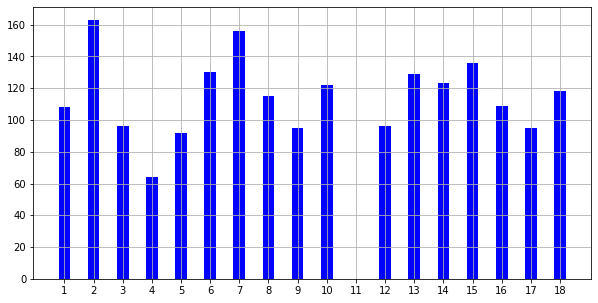

In [10]:
kupp = df_rec[df_rec['Year'] == '2021']
count = 0
lst_week = []
lst_yds = []
for index,row in kupp.iterrows():
    lst_week.append(int(row['Week']))
    lst_yds.append(int(row['RecYd']))
#print(lst_week,lst_yds)
fig = plt.figure(figsize = (10, 5))
plt.bar(lst_week, lst_yds, color = 'blue',width=0.4)
plt.grid(True)
plt.xticks(range(1, 19))       
plt.show()